In [1]:
import os
import shutil
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Chemins d'accès
base_dir = './dataset/'
src_images_dir = './dataset/images/'
src_labels_dir = './dataset/labels/'

In [3]:
# Définie les chemins de destination pour les ensembles train, validation et test
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [4]:
# Crée les dossiers s'ils n'existent pas déjà
for dir in [train_dir, val_dir, test_dir]:
    os.makedirs(dir, exist_ok=True)
    os.makedirs(os.path.join(dir, 'accident'), exist_ok=True)
    os.makedirs(os.path.join(dir, 'no_accident'), exist_ok=True)

In [5]:
# Obtenir une liste de toutes les images et les mélanger
all_images = [f for f in os.listdir(src_images_dir) if f.endswith('.jpg')]
np.random.shuffle(all_images)

In [6]:
# Répartition des données: 70% train, 20% validation, 10% test
num_train = int(len(all_images) * 0.7)
num_val = int(len(all_images) * 0.2)
num_train,num_val

(3522, 1006)

In [7]:
train_images = all_images[:num_train]
val_images = all_images[num_train:num_train + num_val]
test_images = all_images[num_train + num_val:]

In [8]:
len(train_images),len(val_images),len(test_images)

(3522, 1006, 504)

In [9]:
# Fonction pour copier les images dans le bon dossier en fonction des labels
def copy_images(images, dest_dir):
    for image in tqdm(images,total=len(images)):
        # Lire le label correspondant
        label_file = os.path.join(src_labels_dir, image.replace('.jpg', '.txt'))
        with open(label_file, 'r') as f:
            label = f.read().strip()
        # Déterminez la classe en fonction du contenu du label
        class_dir = 'accident' if label != '' else 'no_accident'
        # Copiez l'image dans le dossier correspondant
        shutil.copy(os.path.join(src_images_dir, image), os.path.join(dest_dir, class_dir, image))

In [10]:
# Copie des images dans les dossiers appropriés
copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

100%|███████████████████████████████████████████████████████████████████████████████| 504/504 [00:03<00:00, 164.10it/s]


In [11]:
# Paramètres de base pour le chargement des images
img_height, img_width = 224, 224 
batch_size = 32  

In [26]:
# Preparation des ensembles de données d'entrainement, de test et de validation
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=101,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=101,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=101,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5011 files belonging to 2 classes.
Found 3844 files belonging to 2 classes.
Found 2677 files belonging to 2 classes.


In [13]:
# Vérification des Noms des Classes
class_names = training_ds.class_names
print("Classes found:", class_names)

Classes found: ['accident', 'no_accident']


In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
img_shape = (img_height, img_width, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [25]:
# Creation du modele

In [16]:
model = tf.keras.Sequential([
    base_model,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(len(class_names), activation= 'softmax')
])

In [17]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ ?                           │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
history = model.fit(training_ds, validation_data = validation_ds, epochs = 5)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.5863 - loss: 0.7149 - val_accuracy: 0.6990 - val_loss: 0.5741
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.7162 - loss: 0.5453 - val_accuracy: 0.7750 - val_loss: 0.4458
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.7940 - loss: 0.4327 - val_accuracy: 0.8520 - val_loss: 0.3707
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.8338 - loss: 0.3608 - val_accuracy: 0.8879 - val_loss: 0.2772
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.8800 - loss: 0.2871 - val_accuracy: 0.9246 - val_loss: 0.1966


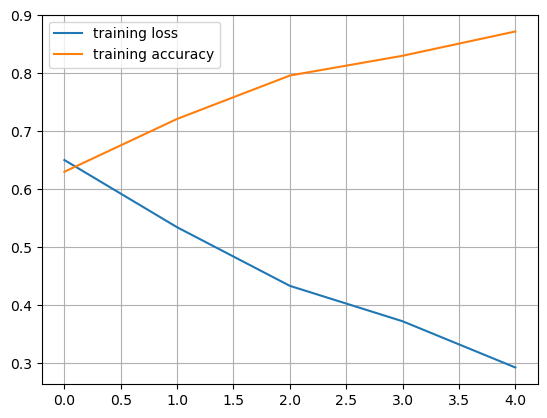

In [20]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

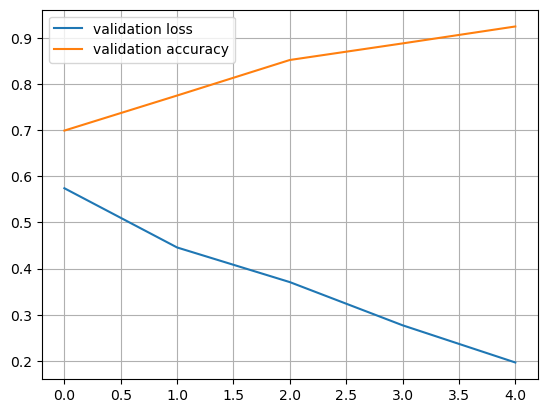

In [21]:
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [22]:
print(class_names)

['accident', 'no_accident']


In [23]:
def predict_frame(img):
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    prediction=(model.predict(img_batch) > 0.5).astype("int32")
    if(prediction[0][0]==0):
        return("Accident Detected")
    else:
        return("No Accident")
    

In [24]:
del model